In [1]:
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('train/gt.csv')

In [3]:
df

,title,invoice_number,invoice_number_bbox,issue_date,issue_date_bbox,total,total_bbox,table,table_bbox
0,5f5f7af4-933d-47f6-9fe0-ab05eab6ef71.jpg,1,"[487, 95, 498, 110]",04/04/2020,"[718, 96, 797, 114]",52510,"[816, 1065, 942, 1084]",SI Description of Goods HSN/SAC Quantity Rate ...,"[11, 552, 950, 662]"
1,131f7202-9aae-4a9d-a928-e5e57f62b0ea.jpeg,RSN/18-19/4126,"[608, 130, 720, 142]",09/03/2019,"[733, 130, 847, 142]",76900,"[764, 812, 850, 825]",S Description of Goods HSN/SAC GST Quantity Ra...,"[76, 344, 857, 449]"
2,09922092-d196-471f-86d4-38366beee9e8.png,DEL5-2187145,"[962, 558, 1112, 575]",25/08/2019,"[1000, 618, 1112, 634]",21490,"[1005, 849, 1111, 867]",SI. Net Tax Tax Tax Total\nDescription Unit Pr...,"[83.00039999999998, 668.999825, 1114.0008, 836..."
3,f248a9ed-e8e5-4af0-836f-4eb58886e894.jpeg,FAAOOL1801015598,"[326, 253, 413, 265]",25/09/2017,"[342, 266, 403, 274]",5391,"[509.9, 741.1, 550.8, 762.8]",Product Qty Price COST a Total\nHandsets/ VT59...,"[8.00026, 425.99952, 584.000163, 480.098880000..."
4,4ea82b85-8047-4f49-a6a1-e6de8af5ce0d.png,NaN,[],NaN,[],198.4,"[1123, 756, 1190, 770]",Date Item Description Total Unit Costs Tax Rat...,"[35.000112, 566.000385, 1194.99996, 647.99998]"
...,...,...,...,...,...,...,...,...,...
56,22061e07-c158-4548-ae2d-f40e20dabb73.png,4444 Po AB123,"[317.5, 681.9, 410.2, 695.8]",15/09/2010,"[535, 108, 601, 118]",1800,"[682, 680, 740, 690]",11. 12 Specification of commodities (und of pa...,"[28.999912, 419.00032, 740.9997800000001, 497...."
57,bbceab98-2049-487b-bc29-85dee1daad7f.jpg,205,"[600, 155, 619, 162]",11/03/1993,"[59, 396, 114, 407]",280832,"[649, 880, 709, 890]",UNIT EXTENDED\nPRICE PRICE\nQUANTITY ITEM DESC...,"[52.000364, 437.00000000000006, 717.0004660000..."
58,897aa322-67ca-4eb0-801c-6db864c6af49.jpg,NaN,[],05/07/2015,"[588, 181, 639, 188]",24,"[763, 555, 787, 561]",11 12 Spectation of commodities (kind of packa...,"[59.9998, 353.99980000000005, 799.999600000000..."
59,f1b24122-4e43-4540-b035-e245de3b6d68.jpg,BT-1638,"[627, 80, 667, 88]",03/01/2002,"[80, 856, 124, 863]",309400,"[638, 695, 673, 703]","Line Country\nNo. Item Number, Harmonized Numb...","[41.999840000000006, 380.00032, 681.0001920000..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                61 non-null     object
 1   invoice_number       49 non-null     object
 2   invoice_number_bbox  61 non-null     object
 3   issue_date           58 non-null     object
 4   issue_date_bbox      61 non-null     object
 5   total                60 non-null     object
 6   total_bbox           61 non-null     object
 7   table                61 non-null     object
 8   table_bbox           61 non-null     object
dtypes: object(9)
memory usage: 4.4+ KB


In [5]:
df.dropna(inplace=True)

In [6]:
df

,title,invoice_number,invoice_number_bbox,issue_date,issue_date_bbox,total,total_bbox,table,table_bbox
0,5f5f7af4-933d-47f6-9fe0-ab05eab6ef71.jpg,1,"[487, 95, 498, 110]",04/04/2020,"[718, 96, 797, 114]",52510,"[816, 1065, 942, 1084]",SI Description of Goods HSN/SAC Quantity Rate ...,"[11, 552, 950, 662]"
1,131f7202-9aae-4a9d-a928-e5e57f62b0ea.jpeg,RSN/18-19/4126,"[608, 130, 720, 142]",09/03/2019,"[733, 130, 847, 142]",76900,"[764, 812, 850, 825]",S Description of Goods HSN/SAC GST Quantity Ra...,"[76, 344, 857, 449]"
2,09922092-d196-471f-86d4-38366beee9e8.png,DEL5-2187145,"[962, 558, 1112, 575]",25/08/2019,"[1000, 618, 1112, 634]",21490,"[1005, 849, 1111, 867]",SI. Net Tax Tax Tax Total\nDescription Unit Pr...,"[83.00039999999998, 668.999825, 1114.0008, 836..."
3,f248a9ed-e8e5-4af0-836f-4eb58886e894.jpeg,FAAOOL1801015598,"[326, 253, 413, 265]",25/09/2017,"[342, 266, 403, 274]",5391,"[509.9, 741.1, 550.8, 762.8]",Product Qty Price COST a Total\nHandsets/ VT59...,"[8.00026, 425.99952, 584.000163, 480.098880000..."
5,319ae2a5-5ed5-482c-af1e-186351c11921.jpg,1009624,"[2103, 255, 2231, 278]",08/01/2018,"[2064, 206, 2229, 231]",1431.27,"[953, 2174, 1099, 2203]","Balance Information\nPrevious Balance 6,632.88...","[98.99946200000001, 1559.001, 1100.99900399999..."
6,42b3bb58-def3-4640-80e4-dd6d4741e459.png,76552,"[473, 139, 508, 148]",12/11/2016,"[475, 157, 535, 167]",53000,"[534, 280, 586, 290]",Unit Price Total Amount\nDESCRIPTION Quantity\...,"[9.000072, 188, 592.999848, 241.00032000000002]"
7,f5ef2aae-282b-498c-997f-0f605fd7539d.png,52148,"[400, 262, 441, 273]",01/02/2020,"[792, 264, 898, 274]",220,"[826, 887, 901, 901]",pngtree\nSL. Item Description Price Qty. Total...,"[297, 427, 903, 727]"
8,2dd5fc7e-4406-476c-9a23-838346d07d4f.jpg,#982093,"[437, 17, 513, 32]",20/08/2020,"[32, 175, 133, 187]",2112.25,"[408, 508, 489, 526]",DESCRIPTION QTY. PRICE TOTAL\nWeb Design 1 $20...,"[61, 280, 491, 456]"
9,941652f2-4e5c-4225-9c3c-c2e71a8d41c2.png,INV-17,"[677, 171, 714, 180]",08/02/2020,"[648, 192, 714, 204]",662.75,"[627, 737, 686, 748]",# ITEM & DESCRIPTION DISCOUNT AMOUNT\n1 Brochu...,"[47.999984999999995, 325.999677, 716.999823, 5..."
10,e2072ab9-5e82-4463-a68c-82c7854bb053.png,US-001,"[654, 214, 693, 223]",11/02/2019,"[634, 238, 694, 250]",154.06,"[627, 563, 684, 579]",OTY DESCRIPTION UNIT PRICE AMOUNT\n1 Front and...,"[51.999750000000006, 339.999572, 697.999500000..."


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47 entries, 0 to 59
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                47 non-null     object
 1   invoice_number       47 non-null     object
 2   invoice_number_bbox  47 non-null     object
 3   issue_date           47 non-null     object
 4   issue_date_bbox      47 non-null     object
 5   total                47 non-null     object
 6   total_bbox           47 non-null     object
 7   table                47 non-null     object
 8   table_bbox           47 non-null     object
dtypes: object(9)
memory usage: 3.7+ KB


In [8]:
df["issue_date"] = pd.to_datetime(df["issue_date"], format="%d/%m/%Y")

In [9]:
df

,title,invoice_number,invoice_number_bbox,issue_date,issue_date_bbox,total,total_bbox,table,table_bbox
0,5f5f7af4-933d-47f6-9fe0-ab05eab6ef71.jpg,1,"[487, 95, 498, 110]",2020-04-04,"[718, 96, 797, 114]",52510,"[816, 1065, 942, 1084]",SI Description of Goods HSN/SAC Quantity Rate ...,"[11, 552, 950, 662]"
1,131f7202-9aae-4a9d-a928-e5e57f62b0ea.jpeg,RSN/18-19/4126,"[608, 130, 720, 142]",2019-03-09,"[733, 130, 847, 142]",76900,"[764, 812, 850, 825]",S Description of Goods HSN/SAC GST Quantity Ra...,"[76, 344, 857, 449]"
2,09922092-d196-471f-86d4-38366beee9e8.png,DEL5-2187145,"[962, 558, 1112, 575]",2019-08-25,"[1000, 618, 1112, 634]",21490,"[1005, 849, 1111, 867]",SI. Net Tax Tax Tax Total\nDescription Unit Pr...,"[83.00039999999998, 668.999825, 1114.0008, 836..."
3,f248a9ed-e8e5-4af0-836f-4eb58886e894.jpeg,FAAOOL1801015598,"[326, 253, 413, 265]",2017-09-25,"[342, 266, 403, 274]",5391,"[509.9, 741.1, 550.8, 762.8]",Product Qty Price COST a Total\nHandsets/ VT59...,"[8.00026, 425.99952, 584.000163, 480.098880000..."
5,319ae2a5-5ed5-482c-af1e-186351c11921.jpg,1009624,"[2103, 255, 2231, 278]",2018-01-08,"[2064, 206, 2229, 231]",1431.27,"[953, 2174, 1099, 2203]","Balance Information\nPrevious Balance 6,632.88...","[98.99946200000001, 1559.001, 1100.99900399999..."
6,42b3bb58-def3-4640-80e4-dd6d4741e459.png,76552,"[473, 139, 508, 148]",2016-11-12,"[475, 157, 535, 167]",53000,"[534, 280, 586, 290]",Unit Price Total Amount\nDESCRIPTION Quantity\...,"[9.000072, 188, 592.999848, 241.00032000000002]"
7,f5ef2aae-282b-498c-997f-0f605fd7539d.png,52148,"[400, 262, 441, 273]",2020-02-01,"[792, 264, 898, 274]",220,"[826, 887, 901, 901]",pngtree\nSL. Item Description Price Qty. Total...,"[297, 427, 903, 727]"
8,2dd5fc7e-4406-476c-9a23-838346d07d4f.jpg,#982093,"[437, 17, 513, 32]",2020-08-20,"[32, 175, 133, 187]",2112.25,"[408, 508, 489, 526]",DESCRIPTION QTY. PRICE TOTAL\nWeb Design 1 $20...,"[61, 280, 491, 456]"
9,941652f2-4e5c-4225-9c3c-c2e71a8d41c2.png,INV-17,"[677, 171, 714, 180]",2020-02-08,"[648, 192, 714, 204]",662.75,"[627, 737, 686, 748]",# ITEM & DESCRIPTION DISCOUNT AMOUNT\n1 Brochu...,"[47.999984999999995, 325.999677, 716.999823, 5..."
10,e2072ab9-5e82-4463-a68c-82c7854bb053.png,US-001,"[654, 214, 693, 223]",2019-02-11,"[634, 238, 694, 250]",154.06,"[627, 563, 684, 579]",OTY DESCRIPTION UNIT PRICE AMOUNT\n1 Front and...,"[51.999750000000006, 339.999572, 697.999500000..."


In [10]:
df['Year'] = df['issue_date'].dt.year
df['Month'] = df['issue_date'].dt.month
df['Day'] = df['issue_date'].dt.day

In [11]:
df

,title,invoice_number,invoice_number_bbox,issue_date,issue_date_bbox,total,total_bbox,table,table_bbox,Year,Month,Day
0,5f5f7af4-933d-47f6-9fe0-ab05eab6ef71.jpg,1,"[487, 95, 498, 110]",2020-04-04,"[718, 96, 797, 114]",52510,"[816, 1065, 942, 1084]",SI Description of Goods HSN/SAC Quantity Rate ...,"[11, 552, 950, 662]",2020,4,4
1,131f7202-9aae-4a9d-a928-e5e57f62b0ea.jpeg,RSN/18-19/4126,"[608, 130, 720, 142]",2019-03-09,"[733, 130, 847, 142]",76900,"[764, 812, 850, 825]",S Description of Goods HSN/SAC GST Quantity Ra...,"[76, 344, 857, 449]",2019,3,9
2,09922092-d196-471f-86d4-38366beee9e8.png,DEL5-2187145,"[962, 558, 1112, 575]",2019-08-25,"[1000, 618, 1112, 634]",21490,"[1005, 849, 1111, 867]",SI. Net Tax Tax Tax Total\nDescription Unit Pr...,"[83.00039999999998, 668.999825, 1114.0008, 836...",2019,8,25
3,f248a9ed-e8e5-4af0-836f-4eb58886e894.jpeg,FAAOOL1801015598,"[326, 253, 413, 265]",2017-09-25,"[342, 266, 403, 274]",5391,"[509.9, 741.1, 550.8, 762.8]",Product Qty Price COST a Total\nHandsets/ VT59...,"[8.00026, 425.99952, 584.000163, 480.098880000...",2017,9,25
5,319ae2a5-5ed5-482c-af1e-186351c11921.jpg,1009624,"[2103, 255, 2231, 278]",2018-01-08,"[2064, 206, 2229, 231]",1431.27,"[953, 2174, 1099, 2203]","Balance Information\nPrevious Balance 6,632.88...","[98.99946200000001, 1559.001, 1100.99900399999...",2018,1,8
6,42b3bb58-def3-4640-80e4-dd6d4741e459.png,76552,"[473, 139, 508, 148]",2016-11-12,"[475, 157, 535, 167]",53000,"[534, 280, 586, 290]",Unit Price Total Amount\nDESCRIPTION Quantity\...,"[9.000072, 188, 592.999848, 241.00032000000002]",2016,11,12
7,f5ef2aae-282b-498c-997f-0f605fd7539d.png,52148,"[400, 262, 441, 273]",2020-02-01,"[792, 264, 898, 274]",220,"[826, 887, 901, 901]",pngtree\nSL. Item Description Price Qty. Total...,"[297, 427, 903, 727]",2020,2,1
8,2dd5fc7e-4406-476c-9a23-838346d07d4f.jpg,#982093,"[437, 17, 513, 32]",2020-08-20,"[32, 175, 133, 187]",2112.25,"[408, 508, 489, 526]",DESCRIPTION QTY. PRICE TOTAL\nWeb Design 1 $20...,"[61, 280, 491, 456]",2020,8,20
9,941652f2-4e5c-4225-9c3c-c2e71a8d41c2.png,INV-17,"[677, 171, 714, 180]",2020-02-08,"[648, 192, 714, 204]",662.75,"[627, 737, 686, 748]",# ITEM & DESCRIPTION DISCOUNT AMOUNT\n1 Brochu...,"[47.999984999999995, 325.999677, 716.999823, 5...",2020,2,8
10,e2072ab9-5e82-4463-a68c-82c7854bb053.png,US-001,"[654, 214, 693, 223]",2019-02-11,"[634, 238, 694, 250]",154.06,"[627, 563, 684, 579]",OTY DESCRIPTION UNIT PRICE AMOUNT\n1 Front and...,"[51.999750000000006, 339.999572, 697.999500000...",2019,2,11


In [12]:
df['Year'].value_counts()

Year
2019    10
2018     6
2020     5
2021     5
2017     4
2016     3
2022     3
2008     2
2015     2
2011     1
2014     1
2000     1
2005     1
2010     1
1993     1
2002     1
Name: count, dtype: int64

In [13]:
df['total'] = pd.to_numeric(df['total'], errors='coerce')


In [14]:
df.dropna(inplace=True)

In [15]:
df.iloc[df['total'].idxmax()]

title                           56415ebf-98cc-4050-a4eb-58de6c5d22bf.jpg
invoice_number                                                     34567
invoice_number_bbox                                 [298, 102, 320, 108]
issue_date                                           2022-07-04 00:00:00
issue_date_bbox                                     [362, 101, 404, 107]
total                                                            19860.0
total_bbox                                          [509, 614, 548, 619]
table                  Product Code Description of Goods HS Code Unit...
table_bbox             [41.99995800000001, 309.00021999999996, 550.00...
Year                                                                2022
Month                                                                  7
Day                                                                    4
Name: 25, dtype: object

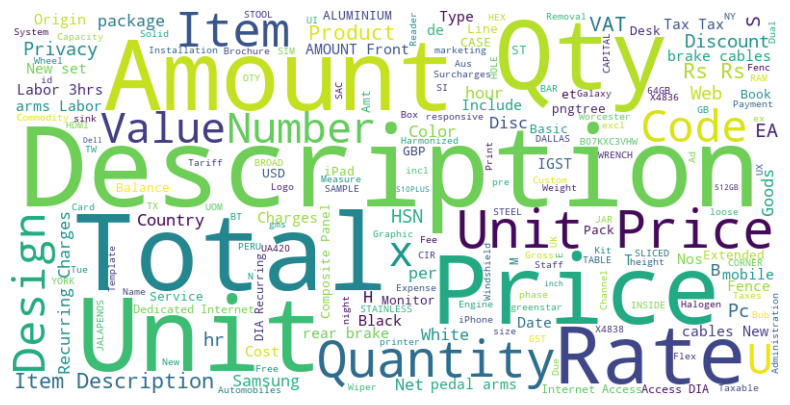

In [16]:
text = ' '.join(df['table'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

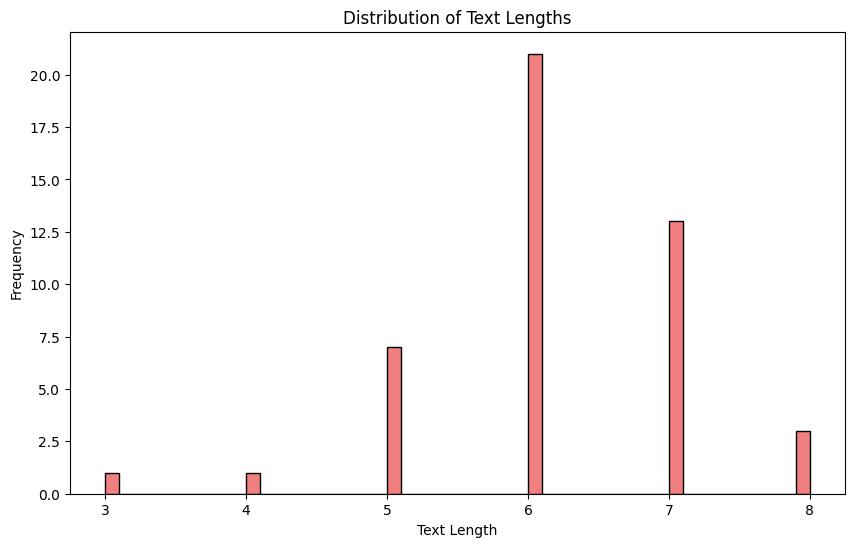

In [17]:
text_lengths = df['total'].apply(lambda x: len(str(x)))

plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=50, color='lightcoral', edgecolor='black')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.show()

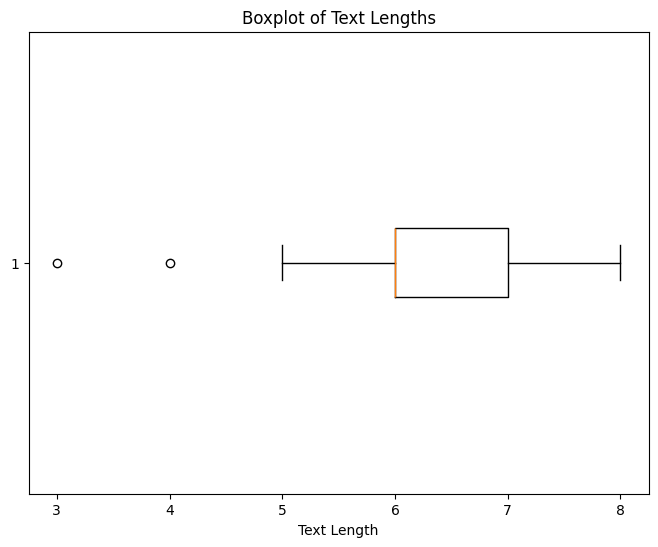

In [18]:
plt.figure(figsize=(8, 6))
plt.boxplot(text_lengths, vert=False)
plt.xlabel('Text Length')
plt.title('Boxplot of Text Lengths')
plt.show()

In [24]:
special_words = ['amount','price', 'unit', 'rate', 'total', 'quantity', 'date', 'code']

In [25]:
words = text.split()

special_words_each = [word.lower() for word in words if word.lower() in special_words]

word_freq = Counter(special_words_each)

word_freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency'])

word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

In [26]:
word_freq_df

,Word,Frequency
5,price,35
4,unit,31
2,amount,27
3,total,26
1,rate,15
0,quantity,13
7,code,9
6,date,4


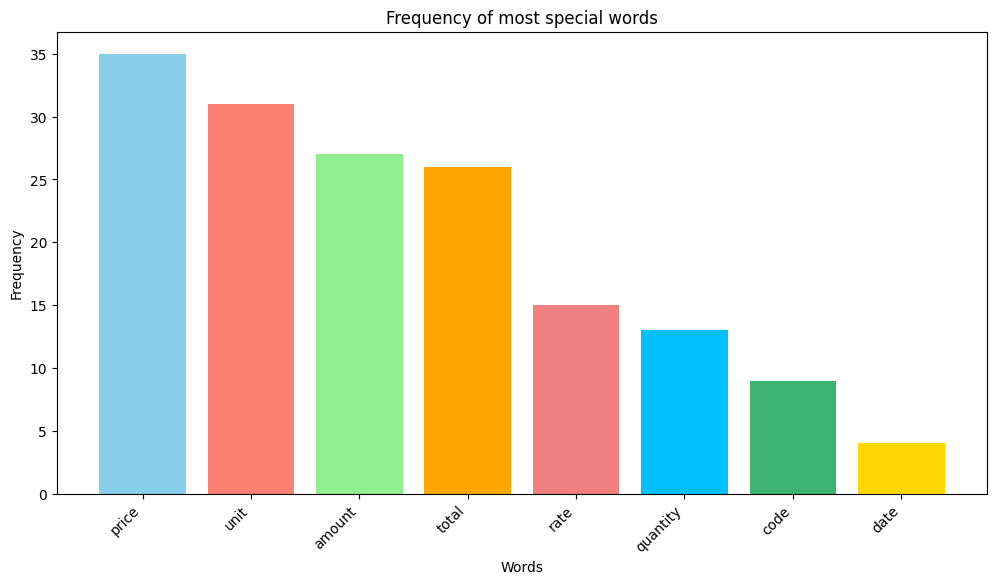

In [31]:
colors = ['skyblue', 'salmon', 'lightgreen', 'orange', 'lightcoral', 'deepskyblue', 'mediumseagreen', 'gold']
plt.figure(figsize=(12, 6))
plt.bar(word_freq_df['Word'][:20], word_freq_df['Frequency'][:20], color=colors)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of most special words')
plt.xticks(rotation=45, ha='right')
plt.show()